# **AI Project – Churn Prediction**

### **Objective**  
The goal of this project is to **develop a machine learning model capable of predicting customer churn** based on behavioral and transactional data.
- Data set from KAGGLE (https://www.kaggle.com/datasets/retailrocket/ecommerce-dataset)

### **Tech Stack Used**

- **Apache Spark (PySpark)** for session-level feature engineering and large-scale data wrangling; **Google Colab / Jupyter**, **NumPy**, **Pandas** for efficient data handling and exploratory analysis.
- **Scikit-learn** for model training and evaluation (Logistic Regression, Decision Tree, Random Forest, metrics like ROC AUC, Precision-Recall, Confusion Matrix) and **Imbalanced-learn** for class imbalance handling (SMOTE, RandomOverSampler).
- **LightGBM (LGBMClassifier)**, **XGBoost (XGBClassifier)**, and **CatBoost (CatBoostClassifier)** for gradient boosting models, along with **Python Standard Libraries** like `datetime` and `numpy` for utility functions.

### **Key Steps Taken**

- **Investigating churn**:  
  - Defined churn clearly based on customer inactivity.
  - Set the prediction goal aligned with business needs.

- **Loading and understanding the data**:  
  - Loaded structured datasets containing session and transaction information.
  - Performed basic exploration to understand distributions, missing values, and data consistency.

- **Initial feature engineering and setup for EDA**:  
  - Created first draft features (e.g., session lengths, frequency measures) to prepare the data for full analysis.
  - Built early aggregates for customer-level insights.

- **Full Exploratory Data Analysis (EDA)**:  
  - Analyzed feature distributions, trends, and correlations.
  - Identified outliers, skewness, and potential data leakage sources.

- **Feature engineering and data cleansing**:  
  - Removed future-leaking features.
  - Built final feature set including behavior patterns (session counts, transaction ratios).
  - Handled missing values and inconsistent records.
  
- **Data splitting**:  
  - Applied a strict **Train / Validation / Test split** using **GroupShuffleSplit** to prevent customer overlap between sets.

- **Model development**:  
  - Trained multiple models including **Logistic Regression**, **Decision Tree**, and **Random Forest**.
  - Focused on **handling class imbalance** using techniques like `class_weight="balanced"`.

- **Model evaluation**:  
  - Measured performance using **ROC AUC**, **precision**, **recall**, and **f1-score**.
  - Carefully evaluated performance on unseen validation and final test sets.

- **Overfitting control**:  
  - Limited tree depth and minimum samples per leaf.
  - Confirmed model stability using **cross-validation** grouped by customer ID.

---

### **Key Results**
- Achieved a **Test AUC of 0.9954** and **99% overall accuracy**.
- Perfect **recall** on churned customers (rare class) with **strong precision**.
- Model generalizes well without signs of overfitting.

---


In [2]:
# --------Starting project with git-------------

# %cd "/content/drive/MyDrive/Colab Notebooks/Final Project/Churn Prediction"
# !pwd
# !git init
# !echo -e ".ipynb_checkpoints/\nsample_data/\ndrive/\n.config/" > .gitignore
# !git add .
# !git commit -m "Initial commit: Churn Prediction project"


In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, LongType, IntegerType, StringType

# Start Spark session
spark = SparkSession.builder.getOrCreate()

# Define schemas
events_schema = StructType([
    StructField("timestamp", LongType(), True),
    StructField("visitorid", IntegerType(), True),
    StructField("event", StringType(), True),
    StructField("itemid", IntegerType(), True),
    StructField("transactionid", IntegerType(), True)
])

item_properties_schema = StructType([
    StructField("timestamp", LongType(), True),
    StructField("itemid", IntegerType(), True),
    StructField("property", StringType(), True),
    StructField("value", StringType(), True)
])

category_tree_schema = StructType([
    StructField("categoryid", IntegerType(), True),
    StructField("parentid", IntegerType(), True)
])

# Load data
events = spark.read.csv(
    "/content/drive/MyDrive/Colab Notebooks/Final Project/Churn Prediction/Data/events.csv",
    header=True,
    schema=events_schema
)

items_properties_part1 = spark.read.csv(
    "/content/drive/MyDrive/Colab Notebooks/Final Project/Churn Prediction/Data/item_properties_part1.csv",
    header=True,
    schema=item_properties_schema
)

items_properties_part2 = spark.read.csv(
    "/content/drive/MyDrive/Colab Notebooks/Final Project/Churn Prediction/Data/item_properties_part2.csv",
    header=True,
    schema=item_properties_schema
)

category_tree = spark.read.csv(
    "/content/drive/MyDrive/Colab Notebooks/Final Project/Churn Prediction/Data/category_tree.csv",
    header=True,
    schema=category_tree_schema
)


In [5]:
items_properties_part1.show(1) # where property is 790 it means that is value columns represnts price

+-------------+------+----------+-----+
|    timestamp|itemid|  property|value|
+-------------+------+----------+-----+
|1435460400000|460429|categoryid| 1338|
+-------------+------+----------+-----+
only showing top 1 row



# Data Cleansing and basic feature engineering, preparing for EDA


In [6]:
from pyspark.sql.functions import col, to_timestamp, to_date, date_format

# Convert from Unix timestamp to actual TIMESTAMP type
events = events.withColumn("ts", to_timestamp(col("timestamp").cast("double")))



events = events.withColumn("ts", to_timestamp((col("timestamp") / 1000).cast("double"))) \
               .withColumn("create_date", to_date(col("ts"))) \
               .withColumn("create_time", date_format(col("ts"), "HH:mm:ss"))


In [7]:
items_properties_part1 = items_properties_part1.withColumn("ts", to_timestamp(col("timestamp").cast("double")))
items_properties_part1 = items_properties_part1.withColumn("ts", to_timestamp((col("timestamp") / 1000).cast("double"))) \
               .withColumn("create_date", to_date(col("ts"))) \
               .withColumn("create_time", date_format(col("ts"), "HH:mm:ss"))

In [8]:
items_properties_part2 = items_properties_part1.withColumn("ts", to_timestamp(col("timestamp").cast("double")))
items_properties_part2 = items_properties_part1.withColumn("ts", to_timestamp((col("timestamp") / 1000).cast("double"))) \
               .withColumn("create_date", to_date(col("ts"))) \
               .withColumn("create_time", date_format(col("ts"), "HH:mm:ss"))

In [9]:
category_tree.show(1)

+----------+--------+
|categoryid|parentid|
+----------+--------+
|      1016|     213|
+----------+--------+
only showing top 1 row



In [10]:

import pyspark.sql.functions as f

# Keep only price, categoryid, and available
items_properties_part1 = items_properties_part1.filter(
    col("property").isin(["790", "categoryid", "available"])
)

items_properties_part2 = items_properties_part2.filter(
    col("property").isin(["790", "categoryid", "available"])
)

# Rename '790' to 'price'
items_properties_part1 = items_properties_part1.withColumn(
    "property",
    f.when(col("property") == "790", "price").otherwise(col("property"))
)

items_properties_part2 = items_properties_part2.withColumn(
    "property",
    f.when(col("property") == "790", "price").otherwise(col("property"))
)


In [11]:
from pyspark.sql.functions import regexp_replace
items_properties_part1 = items_properties_part1.withColumn("value", regexp_replace(col("value"), "[^0-9.]", "").cast("float"))
items_properties_part2 = items_properties_part2.withColumn("value", regexp_replace(col("value"), "[^0-9.]", "").cast("float"))


# Exploratory Data Analysis (EDA)
Objectives:
- Investigate content, datatypes, null values
- Understand user behavior, temporal patterns, and business dynamics.

In [55]:
# events.show(2)
# events.printSchema()


In [ ]:
from pyspark.sql.functions import col, sum as _sum

events.select([_sum(col(c).isNull().cast("int")).alias(c) for c in events.columns]).show() # expected as some action are not transaction


+---------+---------+-----+------+-------------+---+-----------+-----------+
|timestamp|visitorid|event|itemid|transactionid| ts|create_date|create_time|
+---------+---------+-----+------+-------------+---+-----------+-----------+
|        0|        0|    0|     0|      2733644|  0|          0|          0|
+---------+---------+-----+------+-------------+---+-----------+-----------+



In [ ]:
#items_properties_part1.show(1)
items_properties_part1.filter(items_properties_part1.itemid == 355908).show(truncate=False)
items_properties_part1.count()

+-------------+------+----------+-------+-------------------+-----------+-----------+
|timestamp    |itemid|property  |value  |ts                 |create_date|create_time|
+-------------+------+----------+-------+-------------------+-----------+-----------+
|1431831600000|355908|available |1.0    |2015-05-17 03:00:00|2015-05-17 |03:00:00   |
|1440903600000|355908|available |1.0    |2015-08-30 03:00:00|2015-08-30 |03:00:00   |
|1436065200000|355908|available |1.0    |2015-07-05 03:00:00|2015-07-05 |03:00:00   |
|1437879600000|355908|available |1.0    |2015-07-26 03:00:00|2015-07-26 |03:00:00   |
|1431226800000|355908|categoryid|1173.0 |2015-05-10 03:00:00|2015-05-10 |03:00:00   |
|1431226800000|355908|price     |94080.0|2015-05-10 03:00:00|2015-05-10 |03:00:00   |
|1431831600000|355908|price     |94080.0|2015-05-17 03:00:00|2015-05-17 |03:00:00   |
|1433646000000|355908|price     |89280.0|2015-06-07 03:00:00|2015-06-07 |03:00:00   |
|1434250800000|355908|price     |90480.0|2015-06-14 03

2214492

In [12]:
#items_properties_part1.select([_sum(col(c).isNull().cast("int")).alias(c) for c in items_properties_part1.columns]).show() # expected as some action are not transaction
#items_properties_part2.select([_sum(col(c).isNull().cast("int")).alias(c) for c in items_properties_part2.columns]).show() # expected as some action are not transaction
items_properties = items_properties_part1.union(items_properties_part2)


In [ ]:
items_properties.count(), items_properties_part1.count(), items_properties_part2.count() # testing count

(4428984, 2214492, 2214492)

In [13]:
items_properties = items_properties.dropDuplicates()

In [ ]:
category_tree.show(1) # each category falls under 1 parent id, so we can get further insight based on that

+----------+--------+
|categoryid|parentid|
+----------+--------+
|      1016|     213|
+----------+--------+
only showing top 1 row



In [ ]:
category_tree.select([_sum(col(c).isNull().cast("int")).alias(c) for c in category_tree.columns]).show() # expected as some action are not transaction


+----------+--------+
|categoryid|parentid|
+----------+--------+
|         0|      25|
+----------+--------+



In [ ]:
category_tree.filter(col("parentid").isNull()).show()
# these categoryid with parent id == null, it might mean they are parent id itself, hence null
# to be investigated...

+----------+--------+
|categoryid|parentid|
+----------+--------+
|       231|    NULL|
|       791|    NULL|
|      1490|    NULL|
|       431|    NULL|
|       755|    NULL|
|       378|    NULL|
|      1579|    NULL|
|      1394|    NULL|
|       659|    NULL|
|      1057|    NULL|
|       859|    NULL|
|       803|    NULL|
|       250|    NULL|
|      1452|    NULL|
|      1182|    NULL|
|      1692|    NULL|
|      1600|    NULL|
|      1482|    NULL|
|      1224|    NULL|
|      1532|    NULL|
+----------+--------+
only showing top 20 rows



In [ ]:
# Data above seems sturctured well, and no nulls, however I will recheck after the joining of the tables, as I supsect I will get nulls than

In [ ]:
# %cd "/content/drive/MyDrive/Colab Notebooks/Final Project/Churn Prediction"
# !git status
# !git add .
# !git commit -m "Initial cleansing and EDA"

/content/drive/MyDrive/Colab Notebooks/Final Project/Churn Prediction


In [ ]:
# !git commit -m "Initial cleansing and EDA"

[master 8527590] Initial cleansing and EDA
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite churn-prediction.ipynb (98%)


# Feature Engineering

In [62]:
# One important step of the feature engineering is to categorise the actions in time slots,
# I will use half an hour (30 min) slots to categorise sessions, as this is a standart in e-commerce
# Based on that we will be able to see the session stats, and other metrics if they actually end up on a purchase or not

# events
# items_properties
# category_tree

events.show(1)

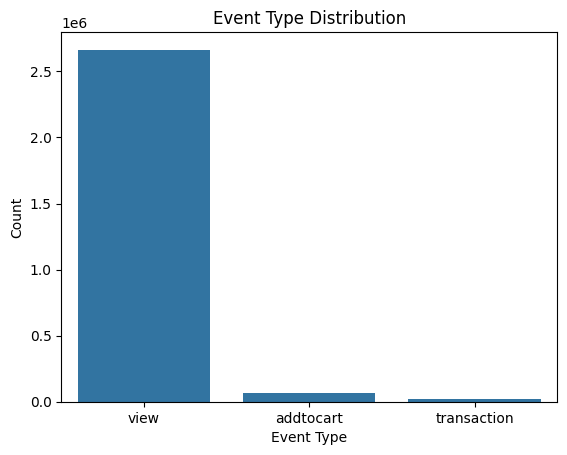

In [65]:
# Checking most common events
events_pd = events.toPandas()
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=events_pd, x="event", order=events_pd["event"].value_counts().index)
plt.title("Event Type Distribution")
plt.xlabel("Event Type")
plt.ylabel("Count")
plt.show()


In [14]:
# Creating session_id so we can get user behaivour based on the sessions

from pyspark.sql import Window


window = Window.partitionBy("visitorid").orderBy("timestamp")

events = events.withColumn("prev_timestamp", f.lag("timestamp").over(window))
events = events.withColumn("gap", (f.col("timestamp") - f.col("prev_timestamp"))/60000)  # gap in minutes

events = events.withColumn("new_session", f.when((f.col("gap") > 30) | f.col("gap").isNull(), 1).otherwise(0))
events = events.withColumn("session_id", f.sum("new_session").over(window))


In [ ]:
events.filter(events.visitorid == 138131).show(1, truncate=False) # checking logic


+-------------+---------+-----+------+-------------+-----------------------+-----------+-----------+--------------+----+-----------+----------+
|timestamp    |visitorid|event|itemid|transactionid|ts                     |create_date|create_time|prev_timestamp|gap |new_session|session_id|
+-------------+---------+-----+------+-------------+-----------------------+-----------+-----------+--------------+----+-----------+----------+
|1430752066267|138131   |view |444451|NULL         |2015-05-04 15:07:46.267|2015-05-04 |15:07:46   |NULL          |NULL|1          |1         |
+-------------+---------+-----+------+-------------+-----------------------+-----------+-----------+--------------+----+-----------+----------+
only showing top 1 row



In [ ]:
# Now I have to join a price, available(based on timestamp), category_id, and parent_category on each event, so that way I can have a price based on the timeframe

In [15]:
from pyspark.sql import Window
import pyspark.sql.functions as f

def join_events_with_prices_category_avail(events, items_properties, category_tree):
    """
    Enrich events with time-correct price, categoryid, isavailable and parent_categoryid,
    filling gaps with each item’s most-stable value. Fixes property mismatch (available vs isavailable).
    """

    # 1 ──────────────────────────────────────────────────────────────
    # split properties
    def prop_df(prop_name, cast_type):
        return (items_properties
                .filter(f.col("property") == prop_name)
                .select("itemid",
                        f.col("timestamp").alias(f"{prop_name}_ts"),
                        f.col("value").cast(cast_type).alias(prop_name)))

    price_df   = prop_df("price",       "double")
    cat_df     = prop_df("categoryid",  "int")
    # Here fix: 'available' instead of 'isavailable'
    avail_df   = (items_properties
                  .filter(f.col("property") == "available")
                  .select("itemid",
                          f.col("timestamp").alias("available_ts"),
                          f.col("value").cast("int").alias("isavailable")))

    # helper to attach latest-before-event value
    def attach_latest(base, df_prop, ts_col):
        win = (Window
               .partitionBy("visitorid", "session_id", "timestamp", "itemid")
               .orderBy(f.col(ts_col).desc_nulls_last()))
        return (base
                .join(df_prop, "itemid", "left")
                .withColumn("rn", f.row_number().over(win))
                .filter(f.col("rn") == 1)
                .drop("rn", ts_col))

    events_enr = attach_latest(events, price_df, "price_ts")
    events_enr = attach_latest(events_enr, cat_df, "categoryid_ts")
    events_enr = attach_latest(events_enr, avail_df, "available_ts")

    # 2 ──────────────────────────────────────────────────────────────
    # build fallback (most-stable values)
    stable = (items_properties
              .filter(f.col("property").isin(["price", "categoryid", "available"]))
              .groupBy("itemid", "property", "value")
              .count()
              .withColumn("rk",
                          f.row_number().over(
                              Window.partitionBy("itemid", "property")
                                    .orderBy(f.desc("count"))))
              .filter("rk = 1")
              .groupBy("itemid")
              .pivot("property")
              .agg(f.first("value"))
              .selectExpr("itemid",
                          "price as price_fb",
                          "categoryid as categoryid_fb",
                          "available as isavailable_fb"))

    # 3 ──────────────────────────────────────────────────────────────
    # coalesce dynamic + fallback
    events_enr = (events_enr
                  .join(stable, "itemid", "left")
                  .withColumn("price",
                              f.coalesce("price", "price_fb").cast("double"))
                  .withColumn("categoryid",
                              f.coalesce("categoryid", "categoryid_fb").cast("int"))
                  .withColumn("isavailable",
                              f.coalesce("isavailable", "isavailable_fb").cast("int"))
                  .drop("price_fb", "categoryid_fb", "isavailable_fb"))

    # 4 ──────────────────────────────────────────────────────────────
    # add parent category
    events_enr = (events_enr
                  .join(category_tree
                          .withColumnRenamed("parentid", "parent_categoryid"),
                        "categoryid",
                        "left"))

    return events_enr


In [ ]:
items_properties.filter(
    (f.col("itemid") == 168952) &
    (f.col("property").isin("price", "available", "categoryid"))
).orderBy("timestamp").show(truncate=False)


+-------------+------+--------+-------+-------------------+-----------+-----------+
|timestamp    |itemid|property|value  |ts                 |create_date|create_time|
+-------------+------+--------+-------+-------------------+-----------+-----------+
|1433646000000|168952|price   |80760.0|2015-06-07 03:00:00|2015-06-07 |03:00:00   |
|1439089200000|168952|price   |75840.0|2015-08-09 03:00:00|2015-08-09 |03:00:00   |
|1441508400000|168952|price   |79080.0|2015-09-06 03:00:00|2015-09-06 |03:00:00   |
|1442113200000|168952|price   |79080.0|2015-09-13 03:00:00|2015-09-13 |03:00:00   |
+-------------+------+--------+-------+-------------------+-----------+-----------+



In [16]:
events_with_price = join_events_with_prices_category_avail(events, items_properties, category_tree)



In [17]:
events_with_price.cache()
#events_with_price.count()

DataFrame[categoryid: int, itemid: int, timestamp: bigint, visitorid: int, event: string, transactionid: int, ts: timestamp, create_date: date, create_time: string, prev_timestamp: bigint, gap: double, new_session: int, session_id: bigint, price: double, isavailable: int, parent_categoryid: int]

In [18]:
events_with_price = events_with_price.drop("gap", "new_session", "prev_timestamp")


In [ ]:
category_tree.show(1)

+----------+--------+
|categoryid|parentid|
+----------+--------+
|      1016|     213|
+----------+--------+
only showing top 1 row



In [19]:
events_with_price = events_with_price.select(
    "timestamp", "ts", "create_date", "create_time",
    "visitorid", "event", "itemid", "categoryid", "parent_categoryid",
    "transactionid", "price", "isavailable", "session_id"
)


In [20]:

#fix null sin categoryid, and parent_categoryid
events_with_price = (events_with_price
    .withColumn("categoryid",
                f.when(f.col("categoryid").isNull(), f.col("itemid"))
                 .otherwise(f.col("categoryid")))
    .withColumn("parent_categoryid",
                f.when(f.col("parent_categoryid").isNull(), f.col("categoryid"))
                 .otherwise(f.col("parent_categoryid"))))


In [ ]:
# Step 1: get distinct itemids with missing price
missing_price_itemids = events_with_price.filter(f.col("price").isNull()).select("itemid").distinct()

# Step 2: check if they exist in items_properties with property = 'price'
items_with_price_property = (items_properties
    .filter(f.col("property") == "price")
    .join(missing_price_itemids, "itemid", "inner")
    .select("itemid")
    .distinct())

# Step 3: show results
items_with_price_property.show(50, truncate=False)


+------+
|itemid|
+------+
+------+



In [21]:
#Droping nulls where the event "transaction" and price = null

events_with_price = events_with_price.filter(
    ~((f.col("event") == "transaction") & (f.col("price").isNull()))
)
#DROPING isavailable, as I do not think it will add value, since it is very messy, and it will add noise to the model
events_with_price = events_with_price.drop("isavailable")


In [ ]:
events_with_price.show(1)

+-------------+--------------------+-----------+-----------+---------+-----+------+----------+-----------------+-------------+-----+-----------+----------+
|    timestamp|                  ts|create_date|create_time|visitorid|event|itemid|categoryid|parent_categoryid|transactionid|price|isavailable|session_id|
+-------------+--------------------+-----------+-----------+---------+-----+------+----------+-----------------+-------------+-----+-----------+----------+
|1434837366894|2015-06-20 21:56:...| 2015-06-20|   21:56:06|   239457| view|   463|       463|              463|         NULL| NULL|       NULL|         1|
+-------------+--------------------+-----------+-----------+---------+-----+------+----------+-----------------+-------------+-----+-----------+----------+
only showing top 1 row



In [ ]:
events_with_price.filter(
    (f.col("event") == "transaction") & (f.col("isavailable").isNull())
).count()


5447

In [ ]:
events_with_price.filter(f.col("event") == "transaction") \
    .groupBy("isavailable") \
    .count() \
    .show()
# is null - 5447

+-----------+-----+
|isavailable|count|
+-----------+-----+
|       NULL| 5447|
|          1| 5971|
|          0| 3804|
+-----------+-----+



**Creating a table on SESSSION LEVEL**

In [ ]:
events_with_price.show(1)

+-------------+--------------------+-----------+-----------+---------+-----+------+----------+-----------------+-------------+-----+----------+
|    timestamp|                  ts|create_date|create_time|visitorid|event|itemid|categoryid|parent_categoryid|transactionid|price|session_id|
+-------------+--------------------+-----------+-----------+---------+-----+------+----------+-----------------+-------------+-----+----------+
|1434837366894|2015-06-20 21:56:...| 2015-06-20|   21:56:06|   239457| view|   463|       463|              463|         NULL| NULL|         1|
+-------------+--------------------+-----------+-----------+---------+-----+------+----------+-----------------+-------------+-----+----------+
only showing top 1 row



In [22]:


def build_session_data(events_df):
    """
    Build session-level data cleanly.
    Args:
        events_df: Spark DataFrame with columns: visitorid, session_id, timestamp, event, price
    Returns:
        sessions_df: session-level Spark DataFrame (1 row = 1 session)
    """

    # 1. Select only required columns
    events_df = events_df.select(
    "visitorid",
    "session_id",
    f.to_timestamp((f.col("timestamp")/1000)).alias("timestamp"),  # 👈 fix here
    "event",
    "price"
      )


    # 2. Group by user and session_id
    sessions_df = events_df.groupBy("visitorid", "session_id").agg(

        # Session timings
        f.min("timestamp").alias("start_time"),
        f.max("timestamp").alias("end_time"),
        ((f.max("timestamp").cast("long") - f.min("timestamp").cast("long")) / 60).alias("session_length_minutes"),

        # Extracted time features
        f.year(f.min("timestamp")).alias("start_year"),
        f.dayofyear(f.min("timestamp")).alias("start_yearday"),
        f.month(f.min("timestamp")).alias("start_month"),
        f.dayofmonth(f.min("timestamp")).alias("start_monthday"),
        f.weekofyear(f.min("timestamp")).alias("start_week"),
        f.dayofweek(f.min("timestamp")).alias("start_weekday"),
        (f.when(f.dayofweek(f.min("timestamp")).isin(1,7), 1).otherwise(0)).alias("start_isweekend"),
        f.hour(f.min("timestamp")).alias("start_hour"),

        # Event counts
        f.sum(f.when(f.col("event") == "view", 1).otherwise(0)).alias("view_count"),
        f.sum(f.when(f.col("event") == "cart", 1).otherwise(0)).alias("cart_count"),
        f.sum(f.when(f.col("event") == "transaction", 1).otherwise(0)).alias("purchase_count"),
        f.count("*").alias("click_count"),

        # Revenues
        f.sum(f.when(f.col("event") == "cart", f.col("price")).otherwise(0.0)).alias("cart_revenue"),
        f.sum(f.when(f.col("event") == "transaction", f.col("price")).otherwise(0.0)).alias("purchase_revenue"),

        # Purchase flag
        f.max(f.when(f.col("event") == "transaction", 1).otherwise(0)).alias("has_purchase"),

        # Time to action metrics
        ((f.max("timestamp").cast("long") - f.min("timestamp").cast("long")) / (60 * f.count("*"))).alias("time_to_click"),
        ((f.max("timestamp").cast("long") - f.min("timestamp").cast("long")) / (60 * f.sum(f.when(f.col("event") == "view", 1).otherwise(0)))).alias("time_to_view"),
        ((f.max("timestamp").cast("long") - f.min("timestamp").cast("long")) / (60 * f.sum(f.when(f.col("event") == "cart", 1).otherwise(0)))).alias("time_to_cart"),
        ((f.max("timestamp").cast("long") - f.min("timestamp").cast("long")) / (60 * f.sum(f.when(f.col("event") == "transaction", 1).otherwise(0)))).alias("time_to_purchase"),

        # Time to revenue metrics
        ((f.max("timestamp").cast("long") - f.min("timestamp").cast("long")) / (60 * f.sum(f.when(f.col("event") == "cart", f.col("price")).otherwise(0.0)))).alias("time_to_cart_revenue"),
        ((f.max("timestamp").cast("long") - f.min("timestamp").cast("long")) / (60 * f.sum(f.when(f.col("event") == "transaction", f.col("price")).otherwise(0.0)))).alias("time_to_purchase_revenue"),
    )

    # 3. Add session_number, inter_session_time, session_recency
    ws = Window.partitionBy("visitorid").orderBy("start_time")
    last_session_time = sessions_df.agg(f.max(f.col("start_time")).alias("last_session")).collect()[0]["last_session"]

    sessions_df = (sessions_df
      .withColumn("session_number", f.row_number().over(ws))
      .withColumn(
          "inter_session_time_days",
          f.when(
              f.lag("start_time", 1).over(ws).isNull(),
              0
          ).otherwise(
              (f.col("start_time").cast("long") - f.lag("start_time", 1).over(ws).cast("long")) / (3600 * 24)
          )
      )
      .withColumn(
          "session_recency_days",
          (f.lit(last_session_time).cast("long") - f.col("start_time").cast("long")) / (3600 * 24)
      )
    )

    return sessions_df


In [23]:
session_data = build_session_data(events_with_price)

In [21]:
session_data.show(1)

+---------+----------+--------------------+--------------------+----------------------+----------+-------------+-----------+--------------+----------+-------------+---------------+----------+----------+----------+--------------+-----------+------------+----------------+------------+-------------+------------+------------+----------------+--------------------+------------------------+--------------+-----------------------+--------------------+
|visitorid|session_id|          start_time|            end_time|session_length_minutes|start_year|start_yearday|start_month|start_monthday|start_week|start_weekday|start_isweekend|start_hour|view_count|cart_count|purchase_count|click_count|cart_revenue|purchase_revenue|has_purchase|time_to_click|time_to_view|time_to_cart|time_to_purchase|time_to_cart_revenue|time_to_purchase_revenue|session_number|inter_session_time_days|session_recency_days|
+---------+----------+--------------------+--------------------+----------------------+----------+--------

In [ ]:
# Get NULL count per column
null_counts = session_data.select([
    f.count(f.when(f.col(c).isNull(), c)).alias(c + "_nulls")
    for c in session_data.columns
])

null_counts.show(truncate=False)


+---------------+----------------+----------------+--------------+----------------------------+----------------+----------------+--------------------+-----------------+------------------+------------------+----------------------+------------------+--------------------+-----------------------------+--------------------------+
|visitorid_nulls|session_id_nulls|start_time_nulls|end_time_nulls|session_length_minutes_nulls|view_count_nulls|cart_count_nulls|purchase_count_nulls|click_count_nulls|view_revenue_nulls|cart_revenue_nulls|purchase_revenue_nulls|has_purchase_nulls|session_number_nulls|inter_session_time_days_nulls|session_recency_days_nulls|
+---------------+----------------+----------------+--------------+----------------------------+----------------+----------------+--------------------+-----------------+------------------+------------------+----------------------+------------------+--------------------+-----------------------------+--------------------------+
|0              |0 

In [24]:
session_data = session_data.drop("view_revenue") # Droping it as contains many nulls, but also weak churn factor

In [ ]:
session_data.show(1)

+---------+----------+-------------+-------------+----------------------+----------+----------+--------------+-----------+------------+----------------+------------+--------------+-----------------------+--------------------+
|visitorid|session_id|   start_time|     end_time|session_length_minutes|view_count|cart_count|purchase_count|click_count|cart_revenue|purchase_revenue|has_purchase|session_number|inter_session_time_days|session_recency_days|
+---------+----------+-------------+-------------+----------------------+----------+----------+--------------+-----------+------------+----------------+------------+--------------+-----------------------+--------------------+
|        1|         1|1439487966444|1439487966444|                   0.0|         1|         0|             0|          1|         0.0|             0.0|           0|             1|                    0.0|  35384.436736111114|
+---------+----------+-------------+-------------+----------------------+----------+----------+-

**Creating a table on USER LEVEL**

In [25]:
def coefficient_of_variation(colname):
    return (f.stddev_samp(colname) / f.mean(colname))

def build_user_table(sessions_df):
    """
    Aggregating session-level data to full user-level table.
    """
    stat_functions = [
        ("mean", f.mean),
        ("sum", f.sum),
        ("min", f.min),
        ("max", f.max),
        ("stddev", f.stddev_samp),
        ("cv", coefficient_of_variation)
    ]

    exclude_cols = set(["visitorid", "session_id", "start_time", "end_time"])
    session_features = [c for c in sessions_df.columns if c not in exclude_cols]

    # Create full list of aggregation expressions
    aggs = []
    for stat_name, stat_func in stat_functions:
        for c in session_features:
            aggs.append(stat_func(c).alias(f"{c}_{stat_name}"))

    # + Ratios
    ratio_expressions = [
        (f.count("session_id") / f.max("session_recency_days")).alias("session_count_ratio"),
        (f.sum("click_count") / f.max("session_recency_days")).alias("click_count_ratio"),
        (f.sum("purchase_count") / f.max("session_recency_days")).alias("transaction_count_ratio"),
    ]
    # Group by user
    user_table = sessions_df.groupBy("visitorid").agg(*aggs, *ratio_expressions)
    return user_table


In [26]:
user_features = build_user_table(session_data)


In [ ]:
## CHECKING NULLS
import pyspark.sql.functions as f

null_counts = user_features.select([
    f.count(f.when(f.col(c).isNull(), c)).alias(f"{c}_nulls")
    for c in user_features.columns
])

null_counts.show(truncate=False)


+---------------+---------------------------------+---------------------+------------------------+----------------------+-------------------------+---------------------+------------------------+--------------------------+---------------------+---------------------+---------------------+-------------------------+----------------------+-----------------------+---------------------------+-----------------------+------------------------+-----------------------+-----------------------+---------------------------+-------------------------------+-----------------------------------+-------------------------+----------------------------------+-------------------------------+--------------------------------+--------------------+-----------------------+---------------------+------------------------+--------------------+-----------------------+-------------------------+--------------------+--------------------+--------------------+------------------------+---------------------+--------------------

In [ ]:
# I will leave nulls for now, I will focus to label the data

In [ ]:
# LABELLING THE DATA

In [27]:
def _get_target(events, split_time, week_target):
    n_weeks = events.agg(
        (f.datediff(f.max("event_time"), f.min("event_time"))/7).alias("dr")
    ).collect()[0]["dr"]

    target = events.select("visitorid").distinct()\
        .join(
            (events.where(f.col("event_time") > split_time)
                .groupBy("visitorid").agg(
                    f.when(f.sum(f.when(f.col("event") == "transaction", 1).otherwise(0)) > 0, 0).otherwise(1).alias("target_event"),
                    f.sum(f.when(f.col("event") == "transaction", f.col("price")).otherwise(0)).alias("target_revenue"))
            ),
            on="visitorid", how="left"
        )\
        .fillna(1, subset=["target_event"])\
        .fillna(0, subset=["target_revenue"])\
        .join(
            events.groupBy("visitorid").agg(
                (week_target * f.sum(f.when(f.col("event") == "transaction", f.col("price")).otherwise(0)) / n_weeks).alias("target_customer_value")
            ),
            on="visitorid", how="left"
        )\
        .fillna(0, subset=["target_customer_value"])

    return target


In [28]:


def _get_target(events, split_time, week_target):
    # 1. Calculate total number of weeks
    n_weeks = events.agg(
        (f.datediff(f.max("event_time"), f.min("event_time"))/7).alias("n_weeks")
    ).collect()[0]["n_weeks"]

    # 2. Find ACTIVE users (users with at least 1 purchase BEFORE split_time)
    active_users = (events
        .where((f.col("event_time") <= split_time) & (f.col("event") == "transaction"))
        .select("visitorid")
        .distinct()
    )

    # 3. For these active users, check if they made a purchase AFTER split_time
    future_purchases = (events
        .where((f.col("event_time") > split_time) & (f.col("event") == "transaction"))
        .groupBy("visitorid")
        .agg(
            f.count("*").alias("future_purchase_count"),
            f.sum(f.col("price")).alias("target_revenue")
        )
    )

    # 4. Define churn target:
    # - If made purchases after split_time -> target_event = 0 (not churn)
    # - Else -> target_event = 1 (churn)
    target = (active_users
        .join(future_purchases, on="visitorid", how="left")
        .withColumn("target_event", f.when(f.col("future_purchase_count") > 0, 0).otherwise(1))
        .withColumn("target_revenue", f.coalesce(f.col("target_revenue"), f.lit(0.0)))
    )

    # 5. Customer Value (scaled profit)
    customer_value = (events
        .where((f.col("event_time") <= split_time) & (f.col("event") == "transaction"))
        .groupBy("visitorid")
        .agg((week_target * f.sum(f.col("price")) / n_weeks).alias("target_customer_value"))
    )

    # 6. Merge everything
    target = (target
        .join(customer_value, on="visitorid", how="left")
        .fillna(0, subset=["target_customer_value"])
    )

    return target


In [29]:

# from pyspark.sql.functions import  from_unixtime




events_with_price = events_with_price.withColumn(
    "event_time",
    (col("timestamp").cast("double") / 1000).cast("timestamp")
)


In [ ]:
events_with_price.agg(
    f.min("event_time").alias("min_time"),
    f.max("event_time").alias("max_time")
).show()


+--------------------+--------------------+
|            min_time|            max_time|
+--------------------+--------------------+
|2015-05-03 03:00:...|2015-09-18 02:59:...|
+--------------------+--------------------+



In [30]:
from datetime import datetime

_target_df = _get_target(
    events=events_with_price,
    split_time = datetime(2015, 7, 1),
    week_target=4 # (or whatever value you want for week_target)
)


In [ ]:
_target_df.groupBy("target_event").count().show()


+------------+-----+
|target_event|count|
+------------+-----+
|           1| 3694|
|           0|   91|
+------------+-----+



In [ ]:
_target_df.show(3)

+---------+---------------------+--------------+------------+---------------------+
|visitorid|future_purchase_count|target_revenue|target_event|target_customer_value|
+---------+---------------------+--------------+------------+---------------------+
|  1168133|                 NULL|           0.0|           1|   19015.652173913044|
|   585885|                 NULL|           0.0|           1|    4504.347826086956|
|   187404|                 NULL|           0.0|           1|   2045.2173913043478|
+---------+---------------------+--------------+------------+---------------------+
only showing top 3 rows



In [31]:
final_df = user_features.join(
    _target_df,
    on="visitorid",
    how="inner"   # only keep users that are in both tables
)




In [30]:
# final_df.show(1)
# final_df.write.mode("overwrite").option("header", "true").csv("/path/where/you/want/final_df.csv")


+---------+---------------------------+---------------+------------------+----------------+-------------------+---------------+------------------+--------------------+---------------+---------------+---------------+-------------------+----------------+-----------------+---------------------+-----------------+------------------+------------------+-----------------+---------------------+-------------------------+-----------------------------+-------------------+----------------------------+-------------------------+--------------------------+--------------+-----------------+---------------+------------------+--------------+-----------------+-------------------+--------------+--------------+--------------+------------------+---------------+----------------+--------------------+----------------+-----------------+-----------------+----------------+--------------------+------------------------+----------------------------+------------------+---------------------------+-----------------------

In [35]:
from pyspark.sql import functions as F

null_counts = final_df.select([
    F.count(F.when(F.col(c).isNull(), c)).alias(c)
    for c in final_df.columns
])

null_counts.show(truncate=False)


+---------+---------------------------+---------------+------------------+----------------+-------------------+---------------+------------------+--------------------+---------------+---------------+---------------+-------------------+----------------+-----------------+---------------------+-----------------+------------------+-----------------+-----------------+---------------------+-------------------------+-----------------------------+-------------------+----------------------------+-------------------------+--------------------------+--------------+-----------------+---------------+------------------+--------------+-----------------+-------------------+--------------+--------------+--------------+------------------+---------------+----------------+--------------------+----------------+-----------------+----------------+----------------+--------------------+------------------------+----------------------------+------------------+---------------------------+------------------------+

In [32]:
final_df = final_df.fillna(0)


In [33]:
final_df_pd = final_df.toPandas()


In [55]:
final_df_pd.head(1)


len

,visitorid,session_length_minutes_mean,start_year_mean,start_yearday_mean,start_month_mean,start_monthday_mean,start_week_mean,start_weekday_mean,start_isweekend_mean,start_hour_mean,...,inter_session_time_days_cv,session_recency_days_cv,session_count_ratio,click_count_ratio,transaction_count_ratio,future_purchase_count,target_revenue,target_event,target_customer_value,time_step
0,1032,2.020833,2015.0,185.0,6.25,26.5,27.25,5.25,0.0,17.25,...,1.987074,0.21302,0.047921,0.083862,0.01198,0,0.0,1,1049.391304,1010


In [34]:
final_df_pd.target_event.value_counts()

,count
target_event,
1,3694
0,91


In [74]:
# Churners = 3 694 of a total 3 785 users → ≈ 97.6 % churn rate. Very common in E-COMMERCE

# Logistic Regression (with class balance)

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, confusion_matrix, precision_score, recall_score,
    f1_score, accuracy_score, classification_report
)
import pandas as pd
# 2. Prepare features and target
X = final_df_pd.drop(columns=[
    'visitorid', 'target_event', 'target_revenue', 'target_customer_value'
])
y = final_df_pd['target_event']

# 3. Train/Test Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. Train model
model = LogisticRegression(class_weight="balanced", random_state=42)

model.fit(X_train, y_train)

# 5. Predict
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# 6. Metrics
auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# 7. Print everything
print(f"ROC AUC: {auc:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


ROC AUC: 0.9138
Accuracy: 0.8996
Precision: 0.9940
Recall: 0.9026
F1 Score: 0.9461

Confusion Matrix:
[[ 14   4]
 [ 72 667]]

Classification Report:
              precision    recall  f1-score   support

           0       0.16      0.78      0.27        18
           1       0.99      0.90      0.95       739

    accuracy                           0.90       757
   macro avg       0.58      0.84      0.61       757
weighted avg       0.97      0.90      0.93       757



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Right now the precision of not-churn is 16%, so only 16 percent of the time the class predicted as not-churn it is actually true
# However the correct classifying of churners as not-churn is 78%, of the time, even though it comes at the cost of many false negative


# Precision of churners is 99%, which is a very good result, so 99% of the time, the class classified as churn it is actually churn
# Recall is that the model managed to correctlt identify 90% of all churners

In [61]:
# %cd "/content/drive/MyDrive/Colab Notebooks/Final Project/Churn Prediction"
# !git status
# !git add .
# !git commit -m "Feature Engineering Complete"

[master 8b63626] Feature Engineering Complete
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite churn-prediction.ipynb (93%)


In [37]:
final_df_pd.head(1)

,visitorid,session_length_minutes_mean,start_year_mean,start_yearday_mean,start_month_mean,start_monthday_mean,start_week_mean,start_weekday_mean,start_isweekend_mean,start_hour_mean,...,session_number_cv,inter_session_time_days_cv,session_recency_days_cv,session_count_ratio,click_count_ratio,transaction_count_ratio,future_purchase_count,target_revenue,target_event,target_customer_value
0,1032,2.020833,2015.0,185.0,6.25,26.5,27.25,5.25,0.0,17.25,...,0.516398,1.987074,0.21302,0.047921,0.083862,0.01198,0,0.0,1,1049.391304


#CatBoost Model

In [83]:
# !pip install catboost
# !pip install -U xgboost  # upgrade to latest (then early_stopping_rounds works)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.9 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.4
    Uninstalling xgboost-2.1.4:
      Successfully uninstalled xgboost-2.1.4


In [41]:
!pip install catboost --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.3 MB/s eta 0:00:00


In [42]:
# 0. If needed: !pip install catboost --quiet

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report

# 1.  Train/test split  (use GroupShuffleSplit if you’re worried about leakage)
X = final_df_pd.drop(columns=['visitorid',
                              'target_event',
                              'target_revenue',
                              'target_customer_value'])
y = final_df_pd['target_event']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

# 2.  Class weights
neg, pos = y_train.value_counts()
class_weights = {0: 1.0, 1: neg / pos}      # e.g. {0:1, 1:35.2}

# 3.  Build CatBoost pools (optional but cleaner)
train_pool = Pool(X_train, y_train)
test_pool  = Pool(X_test,  y_test)

# 4.  Model
model1 = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='AUC',
    class_weights=class_weights,
    iterations=2000,           # plenty; early-stopping will halt earlier
    learning_rate=0.05,
    depth=6,
    random_state=42,
    verbose=200,               # prints every 200 iters; set to False to silence
    od_type='Iter',            # overfitting detector
    od_wait=100                # patience
)

model1.fit(
    train_pool,
    eval_set=test_pool,
    use_best_model=True
)

# 5.  Evaluation
proba = model1.predict_proba(X_test)[:, 1]
preds = (proba > 0.5).astype(int)            # adjust threshold as needed

print(f"AUC: {roc_auc_score(y_test, proba):.4f}")
print(classification_report(y_test, preds))


0:	test: 0.5046234	best: 0.5046234 (0)	total: 79.2ms	remaining: 2m 38s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1
bestIteration = 23

Shrink model to first 24 iterations.
AUC: 1.0000
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        18
           1       0.98      1.00      0.99       739

    accuracy                           0.98       757
   macro avg       0.49      0.50      0.49       757
weighted avg       0.95      0.98      0.96       757



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [49]:
final_df_pd.head(1)

,visitorid,session_length_minutes_mean,start_year_mean,start_yearday_mean,start_month_mean,start_monthday_mean,start_week_mean,start_weekday_mean,start_isweekend_mean,start_hour_mean,...,session_number_cv,inter_session_time_days_cv,session_recency_days_cv,session_count_ratio,click_count_ratio,transaction_count_ratio,future_purchase_count,target_revenue,target_event,target_customer_value
0,1032,2.020833,2015.0,185.0,6.25,26.5,27.25,5.25,0.0,17.25,...,0.516398,1.987074,0.21302,0.047921,0.083862,0.01198,0,0.0,1,1049.391304


# Decision Trees


In [50]:
import re
from sklearn.model_selection import GroupShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, classification_report

# --------------------------------------------------
# 1.  Build a regex for "future-ish" / target columns
# --------------------------------------------------
leak_regex = re.compile(
    r"(future|recency|target_|_ratio$)",  # future*, *recency*, target_*, *_ratio
    flags=re.IGNORECASE
)

# visitorid and label will be handled separately
keepers = [c for c in final_df_pd.columns
           if c not in ("visitorid", "target_event") and not leak_regex.search(c)]

X = final_df_pd[keepers]
y = final_df_pd["target_event"]
groups = final_df_pd["visitorid"]             # keep each customer in one set

# --------------------------------------------------
# 2.  Group-aware train / test split
# --------------------------------------------------
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# --------------------------------------------------
# 3.  Compact, balanced tree
# --------------------------------------------------
tree = DecisionTreeClassifier(
    class_weight="balanced",
    max_depth=6,
    min_samples_leaf=20,
    random_state=42
).fit(X_train, y_train)

proba = tree.predict_proba(X_test)[:, 1]
preds = tree.predict(X_test)

print(f"AUC: {roc_auc_score(y_test, proba):.4f}")
print(classification_report(y_test, preds))


AUC: 0.9940
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        17
           1       1.00      0.99      0.99       740

    accuracy                           0.99       757
   macro avg       0.83      0.99      0.89       757
weighted avg       0.99      0.99      0.99       757



In [52]:
# CHECKING FOR OVERFITING


In [53]:
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
import numpy as np

# 1. Setup
gkf = GroupKFold(n_splits=5)
aucs = []

# 2. Loop over folds
for train_idx, test_idx in gkf.split(X, y, groups=final_df_pd["visitorid"]):
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

    tree = DecisionTreeClassifier(
        class_weight="balanced",
        max_depth=6,
        min_samples_leaf=20,
        random_state=42
    ).fit(X_tr, y_tr)

    proba = tree.predict_proba(X_te)[:, 1]
    auc = roc_auc_score(y_te, proba)
    aucs.append(auc)

# 3. Results
print("Fold AUCs:", np.round(aucs, 4))
print(f"Mean AUC: {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")


Fold AUCs: [0.9983 0.9399 0.9969 0.9965 0.9982]
Mean AUC: 0.9860 ± 0.0230


In [54]:
# No signs of serious overfiting

# Random Forest

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score, classification_report
import numpy as np

# 1. Model setup
rf = RandomForestClassifier(
    n_estimators=300,         # number of trees
    max_depth=6,              # limit depth to prevent overfitting
    min_samples_leaf=20,      # minimum samples in a leaf
    class_weight='balanced',  # auto-handle imbalance
    random_state=42,
    n_jobs=-1                 # use all cores
)

# 2. Group-aware cross-validation (visitorid)
gkf = GroupKFold(n_splits=5)
aucs = []

for train_idx, test_idx in gkf.split(X, y, groups=final_df_pd["visitorid"]):
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

    rf.fit(X_tr, y_tr)
    proba = rf.predict_proba(X_te)[:, 1]
    auc = roc_auc_score(y_te, proba)
    aucs.append(auc)

# 3. Results
print("Fold AUCs:", np.round(aucs, 4))
print(f"Mean AUC: {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")

# 4. Final evaluation (optional - on full train/test split)
rf.fit(X_tr, y_tr)
preds = rf.predict(X_te)
print(classification_report(y_te, preds))


Fold AUCs: [0.9987 0.9972 0.9954 0.9979 0.9968]
Mean AUC: 0.9972 ± 0.0011
              precision    recall  f1-score   support

           0       0.76      1.00      0.86        19
           1       1.00      0.99      1.00       738

    accuracy                           0.99       757
   macro avg       0.88      1.00      0.93       757
weighted avg       0.99      0.99      0.99       757



In [57]:
#----------------------- I will concentrate on the random forest since it is giving me good enough results -----------------------------

In [58]:
from sklearn.model_selection import GroupShuffleSplit

# --------------------------------------------------
# 1.  Shuffle and set up X, y
# --------------------------------------------------
leak_regex = re.compile(r"(future|recency|target_|_ratio$)", flags=re.IGNORECASE)
features_clean = [c for c in final_df_pd.columns
                  if c not in ("visitorid", "target_event") and not leak_regex.search(c)]

X_all = final_df_pd[features_clean]
y_all = final_df_pd["target_event"]
groups_all = final_df_pd["visitorid"]

# Full shuffle
shuffle_idx = np.random.permutation(len(X_all))
X_all = X_all.iloc[shuffle_idx].reset_index(drop=True)
y_all = y_all.iloc[shuffle_idx].reset_index(drop=True)
groups_all = groups_all.iloc[shuffle_idx].reset_index(drop=True)

# --------------------------------------------------
# 2.  Split into train/validation/test
# --------------------------------------------------

# First split: 80% train_val, 20% test
gss1 = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
trainval_idx, test_idx = next(gss1.split(X_all, y_all, groups=groups_all))

X_trainval, X_test = X_all.iloc[trainval_idx], X_all.iloc[test_idx]
y_trainval, y_test = y_all.iloc[trainval_idx], y_all.iloc[test_idx]
groups_trainval = groups_all.iloc[trainval_idx]

# Second split: train_val into 75% train, 25% validation
gss2 = GroupShuffleSplit(test_size=0.25, n_splits=1, random_state=42)
train_idx, val_idx = next(gss2.split(X_trainval, y_trainval, groups=groups_trainval))

X_train, X_val = X_trainval.iloc[train_idx], X_trainval.iloc[val_idx]
y_train, y_val = y_trainval.iloc[train_idx], y_trainval.iloc[val_idx]

# --------------------------------------------------
# 3.  New variable names used:
# X_train, y_train
# X_val, y_val
# X_test, y_test
# --------------------------------------------------

print(f"Train set size: {len(X_train)} rows")
print(f"Validation set size: {len(X_val)} rows")
print(f"Test set size: {len(X_test)} rows")


Train set size: 2271 rows
Validation set size: 757 rows
Test set size: 757 rows


In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report

# --------------------------------------------------
# 1.  Model setup
# --------------------------------------------------
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=6,
    min_samples_leaf=20,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# --------------------------------------------------
# 2.  Train on TRAIN set
# --------------------------------------------------
rf_model.fit(X_train, y_train)

# --------------------------------------------------
# 3.  Validate on VALIDATION set
# --------------------------------------------------
val_proba = rf_model.predict_proba(X_val)[:, 1]
val_preds = rf_model.predict(X_val)

print(f"Validation AUC: {roc_auc_score(y_val, val_proba):.4f}")
print("\nClassification Report on Validation:")
print(classification_report(y_val, val_preds))


Validation AUC: 0.9962

Classification Report on Validation:
              precision    recall  f1-score   support

           0       0.72      1.00      0.84        18
           1       1.00      0.99      1.00       739

    accuracy                           0.99       757
   macro avg       0.86      1.00      0.92       757
weighted avg       0.99      0.99      0.99       757



In [60]:
# --------------------------------------------------
# 1.  Predict on TEST set
# --------------------------------------------------
test_proba = rf_model.predict_proba(X_test)[:, 1]
test_preds = rf_model.predict(X_test)

# --------------------------------------------------
# 2.  Evaluate on TEST set
# --------------------------------------------------
print(f"Test AUC: {roc_auc_score(y_test, test_proba):.4f}")
print("\nClassification Report on Test Set:")
print(classification_report(y_test, test_preds))


Test AUC: 0.9954

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        17
           1       1.00      0.99      0.99       740

    accuracy                           0.99       757
   macro avg       0.84      0.99      0.90       757
weighted avg       0.99      0.99      0.99       757



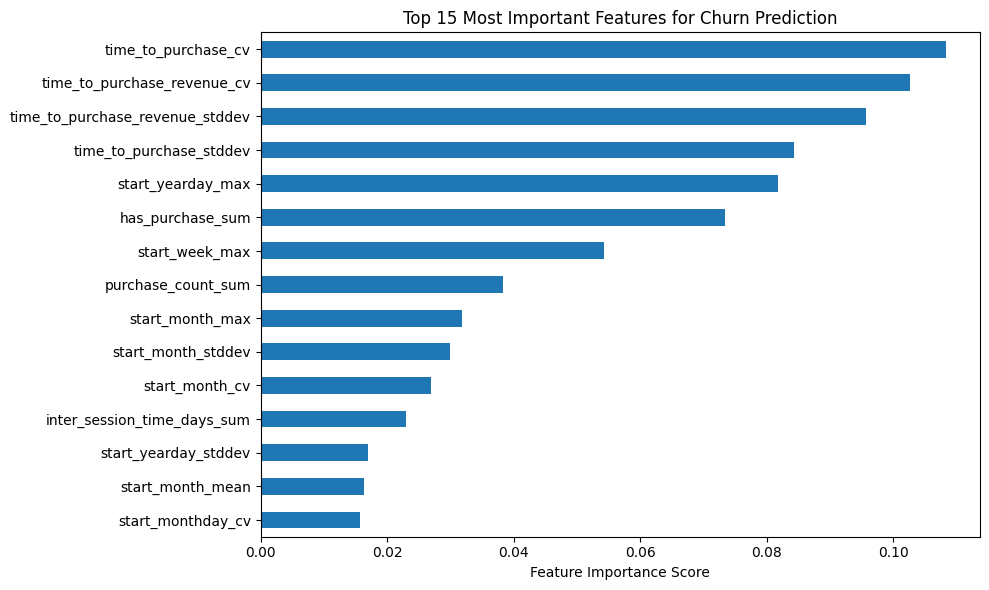

In [62]:
# ------------------------------------ Interpreting the result-------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------------------------------
# 1. Extract feature importances
# --------------------------------------------------
feature_importances = pd.Series(
    rf_model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

# --------------------------------------------------
# 2. Plot top features
# --------------------------------------------------
plt.figure(figsize=(10, 6))
feature_importances.head(15).plot(kind='barh')
plt.gca().invert_yaxis()  # Highest importance on top
plt.title('Top 15 Most Important Features for Churn Prediction')
plt.xlabel('Feature Importance Score')
plt.tight_layout()
plt.show()
